In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

np.random.seed(42)
random_state = np.random.get_state()

In [2]:
# world height, world width
WORLD_HEIGHT = 4
WORLD_WIDTH = 12

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [3, 0]
GOAL = [3, 11]

In [3]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False
    
    reward = -1
    if (action == ACTION_DOWN and i == 2 and 1 <= j <= 10)  \
    or (action == ACTION_RIGHT and state == START):
        reward = -100
        next_state = START
    
    return next_state, reward

# choose an action based on epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        return np.random.choice(np.argwhere(np.max(values_) == values_).flatten())

In [4]:
# an episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, expected=False, step_size=ALPHA):
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0

    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward

        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(np.max(q_next) == q_next)
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target += EPSILON / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA

        q_value[state[0], state[1], action] = q_value[state[0], state[1], action] + step_size * (reward + target - q_value[state[0], state[1], action])

        state = next_state
        action = next_action
    
    return rewards

# an episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA):
    state = START
    rewards = 0.0

    while state != GOAL:
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward

        # Q-Learning update
        q_value[state[0], state[1], action] = q_value[state[0], state[1], action] + step_size * (reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) - q_value[state[0], state[1], action])
        
        state = next_state
    
    return rewards

In [5]:
# Due to limited capacity of calculation of my machine, I can't complete this experiment
# with 100,000 episodes and 50,000 runs to get the fully averaged performance
# However even I only play for 1,000 episodes and 10 runs, the curves liiks still good.
def figure_6_6():
    step_sizes = np.arange(0.1, 1.1, 0.1)
    episodes = 1000
    runs = 10

    ASY_SARSA = 0
    ASY_EXPECTED_SARSA = 1
    ASY_Q_LEARNING = 2
    INT_SARSA = 3
    INT_EXPECTED_SARSA = 4
    INT_Q_LEARNING = 5
    methods = range(0, 6)

    performance = np.zeros((len(methods), len(step_sizes)))

    # for run in range(runs):
    #     for ind, step_size in tqdm(list(zip(range(len(step_sizes)), step_sizes)), desc="{}/{} runs".format(run + 1, runs)):
    #         q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
    #         q_expected_sarsa = np.copy(q_sarsa)
    #         q_q_learning = np.copy(q_sarsa)

    #         for ep in range(episodes):
    #             sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size)
    #             expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size)
    #             q_learning_reward = q_learning(q_q_learning, step_size=step_size)
    #             performance[ASY_SARSA, ind] += sarsa_reward
    #             performance[ASY_EXPECTED_SARSA, ind] += expected_sarsa_reward
    #             performance[ASY_Q_LEARNING, ind] += q_learning_reward
                
    #             if ep < 100:
    #                 performance[INT_SARSA, ind] += sarsa_reward
    #                 performance[INT_EXPECTED_SARSA, ind] += expected_sarsa_reward
    #                 performance[INT_Q_LEARNING, ind] += q_learning_reward
    

    for ind, step_size in tqdm(list(zip(range(len(step_sizes)), step_sizes))):
        np.random.set_state(random_state)
        for run in range(runs):
            q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
            for ep in range(episodes):
                sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size)
                performance[ASY_SARSA, ind] += sarsa_reward
                if ep < 100:
                    performance[INT_SARSA, ind] += sarsa_reward

        np.random.set_state(random_state)
        for run in range(runs):
            q_expected_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
            for ep in range(episodes):
                expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size)
                performance[ASY_EXPECTED_SARSA, ind] += expected_sarsa_reward
                if ep < 100:
                    performance[INT_EXPECTED_SARSA, ind] += expected_sarsa_reward

        np.random.set_state(random_state)
        for run in range(runs):
            q_q_learning = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
            for ep in range(episodes):
                q_learning_reward = q_learning(q_q_learning, step_size=step_size)
                performance[ASY_Q_LEARNING, ind] += q_learning_reward
                if ep < 100:
                    performance[INT_Q_LEARNING, ind] += q_learning_reward
    
    performance[:3, :] /= episodes * runs
    performance[3:, :] /= 100 * runs

    labels = [
        "Asymptotic Sarsa", "Asymptotic Expected Sarsa", "Asymptotic Q-Learning",
        "Interim Sarsa", "Interim Expected Sarsa", "Interim Q-Learning"]
    linestyles = [
        "solid", "solid", "solid",
        "dashdot", "dashdot", "dashdot"]
    for method, label, linestyle in zip(methods, labels, linestyles):
        plt.plot(step_sizes, performance[method, :], label=label, linestyle=linestyle)
    plt.xlabel("alpha")
    plt.ylabel("reward per episode")
    plt.legend()
    plt.show()


100%|██████████| 10/10 [07:04<00:00, 42.44s/it]


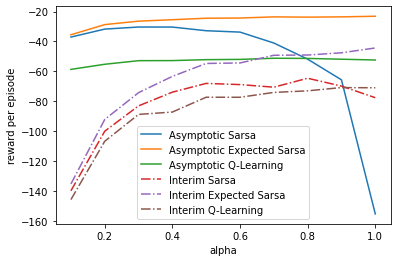

In [6]:
figure_6_6()